## Toy example for DKLP on simulated datasets

In [1]:
from helper import *
from gen_sim_data import *
import matplotlib.pyplot as plt
import numpy as np
import importlib
import matplotlib.cm as cm

### Nonparametric regression

In [2]:
### generate data from nonparameteric regression
# npr_data = gen_data_npr(N=50, d=1, img_shape=[900], kernel='RBF', ls=0.1, var=1, sig=1, n_sim=1)
# save_pickle(npr_data, '../data/NPR_data.pickle')

In [3]:
npr_data = load_pickle('../data/NPR_data.pickle')
sim_data = npr_data['data']
i=0
S = npr_data['grid']
y = sim_data[0]['y']
f = sim_data[0]['f']
V_total = y.shape[0]

Pickle loaded from ../data/NPR_data.pickle


In [4]:
import DKLP_NPR
DKLP_NPR = importlib.reload(DKLP_NPR)
torch.manual_seed(0)
npr_model = DKLP_NPR.NPR( S=S, Y=y, pred_S=S,
        J = 20, H = 128, M=3,
        burnin=1000, thin=1, mcmc_sample=1000,lr=1e-8)
npr_model.fit()


In [5]:
npr_post = npr_model.post_summary()
maineff = npr_post['maineff']

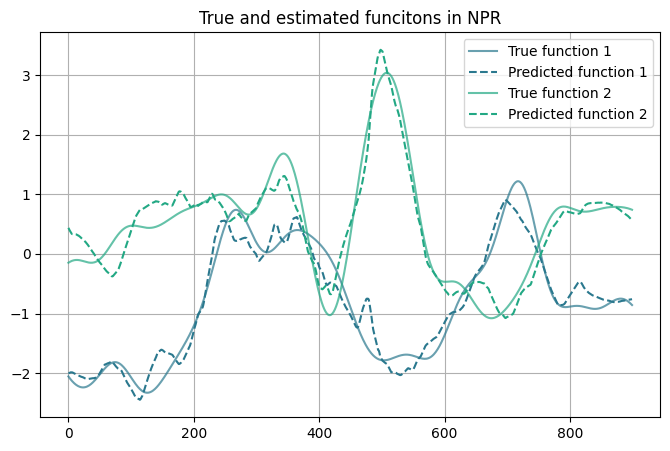

In [6]:
colors = cm.viridis(np.linspace(0.4, 0.8, 3))  
plt.figure(figsize=(8, 5))  

for i in range(2):
    plt.plot(f[:, i], color=colors[i], linestyle='-', label=f'True function {i+1}', alpha=0.7)
    plt.plot(maineff[:, i], color=colors[i], linestyle='--', label=f'Predicted function {i+1}')

plt.title("True and estimated funcitons in NPR")
plt.legend()
plt.grid(True)
plt.show()

### Image-on-Scalar Regression

In [7]:
is_data = load_pickle('../data/IS_data.pickle')
sim_data = is_data['sim_data']
i=0
S = is_data['true_paras']['grid']
y = sim_data[0]['y']
f = sim_data[0]['f']
X = sim_data[0]['X']
beta = is_data['true_paras']['beta']

Pickle loaded from ../data/IS_data.pickle


In [8]:
import DKLP_IS
torch.manual_seed(0)
DKLP_IS = importlib.reload(DKLP_IS)
is_model = DKLP_IS.IS(S=S, Y=y, X=X,  include_intercept=False,
                      J=50, H=256, M=4, act_fn='relu',
                      first_burnin=100, second_burnin = 1000, 
                      thin=1, mcmc_sample=1000, 
                      lr=0.0001, batch_size = None)
is_model.fit()

In [9]:
is_post = is_model.post_summary(level=0.01)
maineff = is_post['maineff']

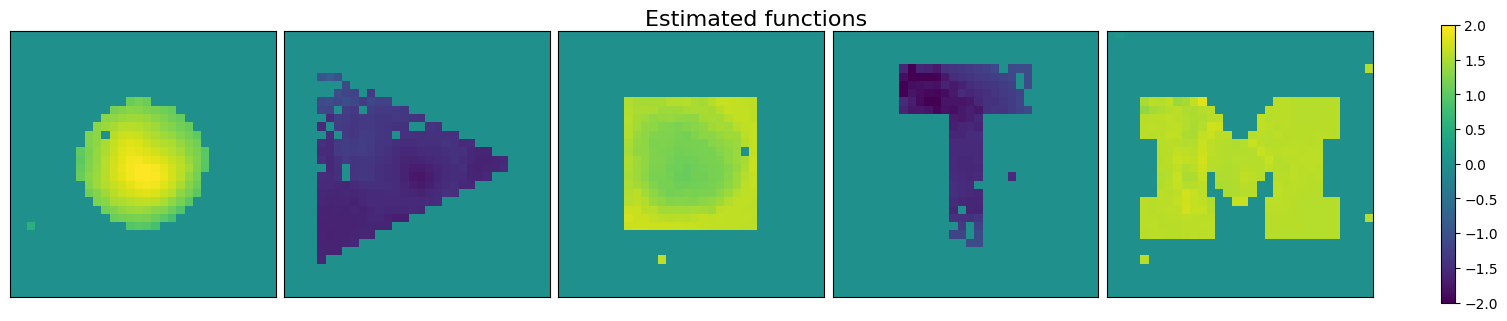

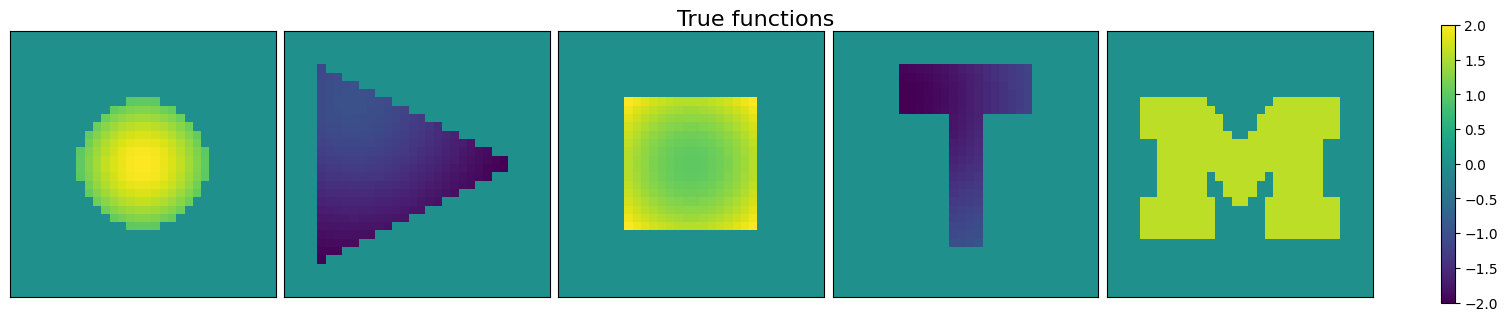

In [10]:
img_min = torch.min(beta)
img_max = torch.max(beta)
J = X.shape[1]
fig, axes = plt.subplots(nrows=1, ncols=J, figsize=(15, 3), constrained_layout = True)

for j in range(J):
    ax = axes[j]
    ax.set_xticks([])
    ax.set_yticks([])
    beta_reshape_j = maineff[j,:].reshape((32,32))
    shapes = ax.imshow(beta_reshape_j,vmin=img_min, vmax=img_max)
            
cbar = fig.colorbar(shapes, ax=axes.ravel().tolist())
fig.suptitle("Estimated functions", fontsize=16, y=1.02)
plt.show()

fig, axes = plt.subplots(nrows=1, ncols=J, figsize=(15, 3), constrained_layout = True)
for j in range(J):
    ax = axes[j]
    ax.set_xticks([])
    ax.set_yticks([])
    beta_reshape_j = beta[:,j].reshape((32,32))
    shapes = ax.imshow(beta_reshape_j,vmin=img_min, vmax=img_max)
            
cbar = fig.colorbar(shapes, ax=axes.ravel().tolist())
fig.set_tight_layout
fig.suptitle("True functions", fontsize=16, y=1.02)

plt.show()
  

### Scalar-on-Image Regression

In [11]:
si_data = load_pickle('../data/SI_data.pickle')
train_data = si_data['train_data']
i=0
S = si_data['grid']
U = train_data[i][0]
Y = train_data[i][1]
X = train_data[i][2]
beta = si_data['true_paras'][0]

Pickle loaded from ../data/SI_data.pickle


In [12]:
import DKLP_SI 
torch.manual_seed(0)
DKLP_SI = importlib.reload(DKLP_SI)
si_model = DKLP_SI.SI(S=S, Y=Y, X=X, U=U,
                J = 100, H = 256, 
                first_burnin=100, second_burnin = 1000, 
                thin=1, mcmc_sample=1000,
                lr=0.00001, batch_size=300)
si_model.fit()

In [13]:
si_post = si_model.post_summary(level=0.05)
maineff = si_post['maineff']

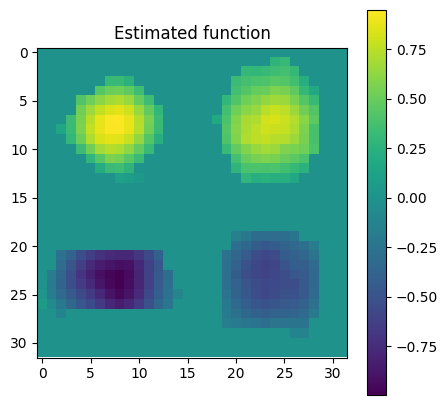

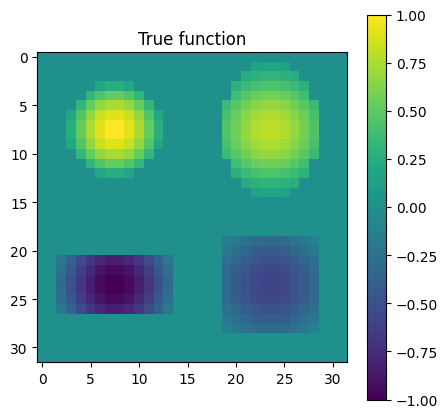

In [14]:
fig_t=plt.figure(figsize=(5,5))
plt.imshow((maineff).reshape((32,32)))
plt.title('Estimated function')
plt.colorbar()
fig_t=plt.figure(figsize=(5,5))
plt.imshow((beta).reshape((32,32)))
plt.title('True function')
plt.colorbar()